    8) 전문가 지식활용
    
        - 특성공학은 전문가의 지식을 사용할 수 있는 중요한 영역이다. 
          ( 초기 데이터에서 더 유용한 특성을 선택할 수 있도록 도움을 줄 수 있다 )
          
        - 예를 들어 여행사의 항공료 예측시, 날짜, 항공사, 출발지, 도착지와 함께 가격을 기록할 수 있지만
          휴가, 성수기, 음력 공휴일과 같이 학습될 수 없는 요소 등의 전문가의 지식이 추가가 된다면
          더욱 성능이 좋은 모델을 만들 수 있을 것.

In [1]:
#예제는 자전거 대여 데이터 

import mglearn

citibike = mglearn.datasets.load_citibike()

print('시티 바이트 데이터 :', citibike)

c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib

시티 바이트 데이터 : starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
                       ..
2015-08-31 09:00:00    16
2015-08-31 12:00:00     8
2015-08-31 15:00:00    17
2015-08-31 18:00:00    22
2015-08-31 21:00:00     7
Freq: 3H, Name: one, Length: 248, dtype: int64


Text(0, 0.5, 'count')

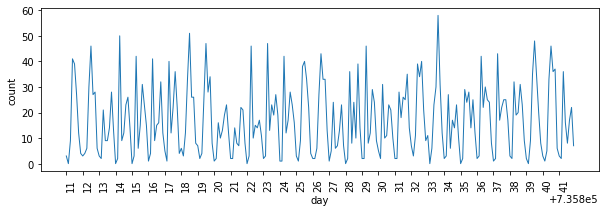

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize = (10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
week = ['SUN','MON','TUE','WED','THU','FRI','SAT']
xticks_name = [week[int(w)]+d for w, d in zip(xticks.strftime('%w'), xticks.strftime(' %m-%d'))]
plt.xticks(xticks, xticks.name, rotation = 90, ha = 'left')
plt.plot(citibike, linewidth = 1)
plt.xlabel('day')
plt.ylabel('count')

24시간 간격으로 낝과 밥을 구분 가능하며, 주말과 주중 패턴의 차이도 있는 것을 확인.

시계열 데이터 이용 예측은 과거 데이터를 학습하여 미래를 예측하는 방식 이용

In [5]:
#타깃값 추출(대여횟수)
y = citibike.values

#POSIX 시간을 10**9로 나누어 변환
X = citibike.index.astype('int64').values.reshape(-1,1)//10**9

In [11]:
#처음 184개 데이터를 Train data로 이용, 나머지는 Test data
n_train = 184

#특성 이용 평가 및 시각화

def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print('TEST SET R2 : ', regressor.score(X_test, y_test))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize = (10, 3))
    
    plt.xticks(range(0, len(X), 8), xticks_name, rotation = 90, ha = 'left')
    
    plt.plot(range(n_train), y_train, label = 'Train')
    plt.plot(range(n_train, len(y_test)+n_train), y_test, '-', label='test')
    plt.plot(range(n_train), y_pred_train, '--', label='Train predict')
    
    plt.plot(range(n_train, len(y_test)+n_train), y_pred, '--', label='Test predict')
    plt.legend(loc=(1.01, 0))
    plt.xlabel('day')
    plt.ylabel('count')

TEST SET R2 :  -0.035486463625959086


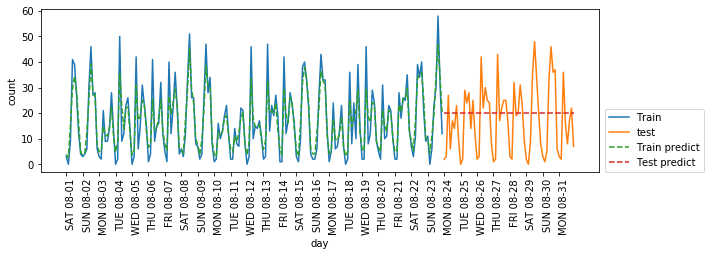

In [12]:
#랜덤포레스트는 전처리가 거의 필요하지 않아 시도해보기 좋은 모델

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
eval_on_features(X, y, regressor)

훈련 세트의 예측은 매우 정확하지만, 테스트 세트에 대해선 한 값으로 예측.

R2값은 -0.04로 거의 아무것도 학습되지 않았다는 것을 나타낸다. 

테스트 셋의 POSIX 시간 특성의 값은 훈련 세트 값의 범위 밖이다. 

트리 기반 모델들은 특성 범위의 밖으로 와삽(extrapolation)할 수 있는 능력이 없다. 

결국 테스트 셋의 가장 가까이 있는 마지막 훈련 세트 데이터의 타깃값을 예측으로 사용하게 된다. 

TEST SET R2 :  0.5995775993305429


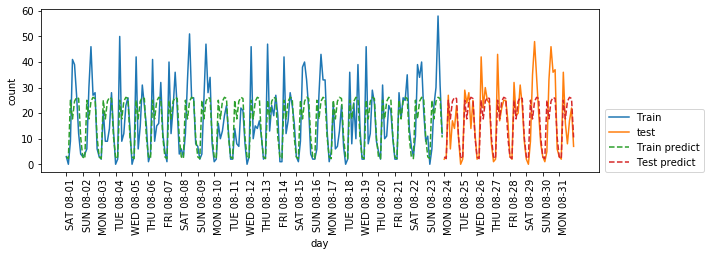

In [14]:
#POSIX 특성을 제거하고 시간과 요일을 추가해본다. 
X_hour = citibike.index.hour.values.reshape(-1,1)
eval_on_features(X_hour, y, regressor)

POSIX이용보단 나아졌지만 주간 패턴 예측 성능은 떨어지는 것으로 보인다. 

TEST SET R2 :  0.8419488587966025


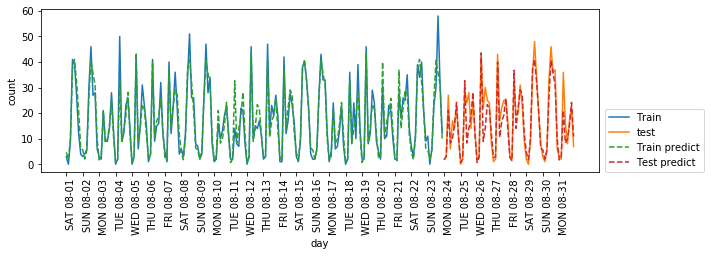

In [18]:
#요일 정보 추가 
import numpy as np
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1,1), citibike.index.hour.values.reshape(-1,1)])
eval_on_features(X_hour_week, y, regressor)

하루의 시간과 요일에 따른 주기적인 패턴을 따르고 있고 R2가 0.84로 상당히 좋은 성능을 내었다. 

TEST SET R2 :  0.13204157262163152


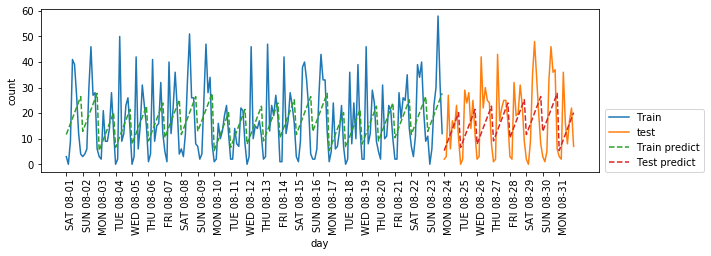

In [20]:
#LinearRegression 적용
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

기본적인 LinearRegression 성능은 훨 씬 나쁘고 주기적인 패턴도 이상하다. 
(요일과 시간이 정수로 인코딩 되어 연속형 변수로 해석되기 때문 )

실제 패턴은 복잡하므로 패턴을 잡아내기 위해 OneHotEncoder 사용하여 정수형 범주형 변수 해석

c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


TEST SET R2 :  0.6222327753706327


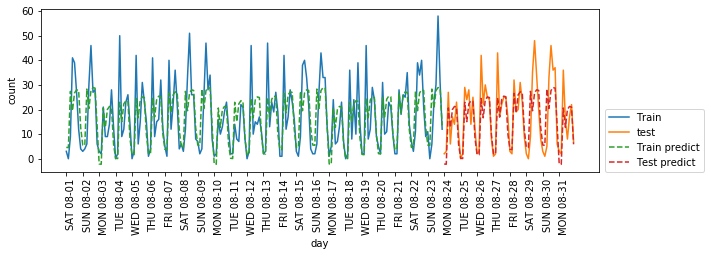

In [21]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

eval_on_features(X_hour_week_onehot, y, LinearRegression())

연속형 특성인 경우 보다 성능이 향상 되었다. 

상호작용 특성을 이용하여 시간과 요일의 조합별 계쑤를 학습 시켜보자

TEST SET R2 :  0.8377770923776383


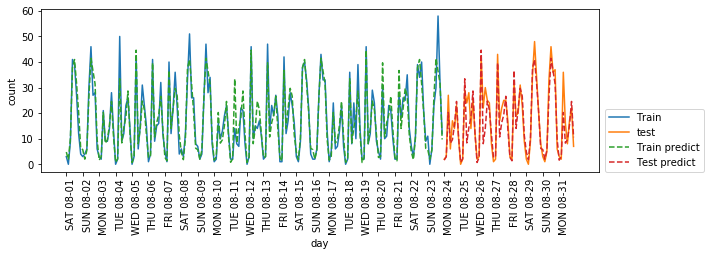

In [26]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr= LinearRegression()
eval_on_features(X_hour_week_onehot_poly, y, lr)

특성 변환을 통해 모델의 성능이 랜덤 포레스트와 비슷 해졌다. 

이 모델의 큰 장점은 무엇이 학습되었는지가 명확하다.

각 날짜와 시간에 대해 하나의 계수를 학습했다. 

랜덤포레스트와 달리 이 모델이 학습한 계수를 그래프로 나타낼 수 있다.

In [27]:
#시간과 요일 특성의 이름을 짓는다.
hour = ['%02d:00' % i for i in range(0, 24, 3)]
day = ['mon','tue','wed','thu','fri','sat','sun']
features = day+hour

In [28]:
features_poly = poly_transformer.get_feature_names(features)
features_nonzero= np.array(features_poly)[lr.coef_!=0]
coef_nonzero = lr.coef_[lr.coef_ !=0]

Text(0, 0.5, 'w ')

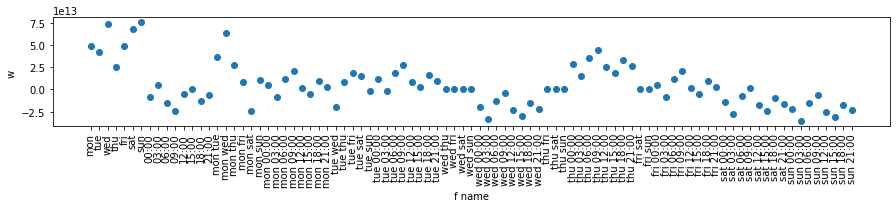

In [29]:
#선형 모델에서 학습한 계수 시각화
plt.figure(figsize = (15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation = 90)
plt.xlabel('f name')
plt.ylabel('w ')